In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
%matplotlib inline
df = pd.read_csv('modelingdf.csv')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['current_compensation'] < 5000000]

In [2]:
df.head()

,A,FC,G,GP,GS,MINS,OFF,R,SHTS,SOG,Y,season,club,position,next_year_compensation,name,current_compensation
0,0.0,7.0,0.0,8.0,5.0,460.0,3.0,0.0,8.0,3.0,0.0,2007,CLB,M,12900,brian plotkin,30000
1,4.0,28.0,3.0,30.0,11.0,1241.0,4.0,0.0,38.0,16.0,5.0,2007,CHI,F,63100,calen carr,50500
2,2.0,21.0,8.0,33.0,28.0,2181.0,37.0,0.0,65.0,41.0,3.0,2007,TFC,F,61273,chad barrett,48713
3,3.0,15.0,8.0,22.0,21.0,1721.0,5.0,0.0,44.0,22.0,1.0,2007,CHI,F,86075,chris rolfe,74700
4,0.0,43.0,1.0,26.0,24.0,2044.0,2.0,0.0,11.0,3.0,4.0,2007,CHI,D,44625,dasan robinson,42500


In [3]:
df = df.drop('name', axis=1)

In [4]:
df = pd.get_dummies(df)

In [5]:
df.shape

(2344, 53)

In [6]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_iter': range(20,110,20), 'epsilon': [1.0, 1.1, 1.2, 1.35, 1.5]}

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state = 12)
X_train = df_train.loc[:, ~(df_train.columns).isin(['next_year_compensation'])]
Y_train = df_train['next_year_compensation']
X_test = df_test.loc[:, ~(df_test.columns).isin(['next_year_compensation'])]
Y_test = df_test['next_year_compensation']

In [8]:
huber = HuberRegressor()
GShuber = GridSearchCV(huber, parameters)

In [9]:
GShuber.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_iter': range(20, 110, 20), 'epsilon': [1.0, 1.1, 1.2, 1.35, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
GShuber.best_params_

{'epsilon': 1.35, 'max_iter': 80}

In [11]:
besthuber = HuberRegressor(epsilon=1.35, max_iter=80)

In [12]:
def get_metrics(model, dataframe):
    x = dataframe.loc[:, ~(df_train.columns).isin(['next_year_compensation'])]
    y = dataframe['next_year_compensation']
    r2_scores = cross_val_score(model, x, y, cv=10)
    r2 = r2_scores.mean()
    mse_scores = cross_val_score(model,x,y, cv=10, scoring='neg_mean_squared_error')
    mse = mse_scores.mean() * -1
    rmse = np.sqrt(mse)
    print(model)
    print('R2 Score:', r2)
    print('MSE:', mse)
    print('RMSE:', rmse)

In [13]:
get_metrics(besthuber, df_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=80,
        tol=1e-05, warm_start=False)
R2 Score: 0.855486599753
MSE: 21490186280.9
RMSE: 146595.314662


In [14]:
def test_metrics(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**(1/2)
    r2 = r2_score(y_test, y_pred)
    print(model)
    print('R2:', r2)
    print('MSE:', mse)
    print('RMSE:', rmse)
    return y_pred

In [15]:
test_prediction = test_metrics(besthuber, X_train, Y_train, X_test, Y_test)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=80,
        tol=1e-05, warm_start=False)
R2: 0.692344850095
MSE: 45027568741.2
RMSE: 212197.004553


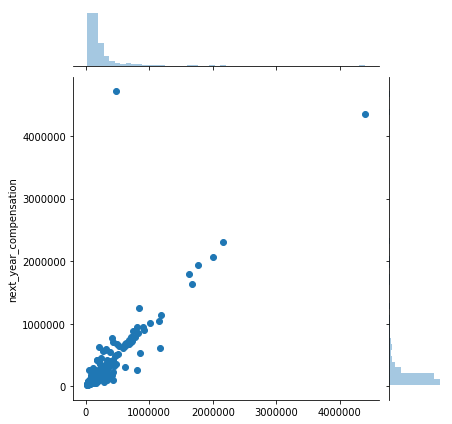

In [16]:
sns.jointplot(x=test_prediction, y= Y_test)

In [20]:
print(besthuber.coef_)
print(besthuber.intercept_)
print(X_train.columns)

[  1.48642952e-02   8.65798517e-02   1.89980251e-02   6.72955680e-02
   7.34352408e-02   6.45270739e+00   2.26423257e-02   7.90351463e-04
   1.41540328e-01   5.50599920e-02   9.17908866e-03   1.16838049e+00
   1.00710497e+00  -3.71260712e-05  -2.67796644e-06  -1.29526528e-04
  -5.56318018e-05  -2.65578839e-04   1.68531926e-04   1.57748336e-04
  -2.83158817e-04   4.32222885e-04  -7.70338652e-05  -6.36271296e-05
   1.96692664e-05   1.79711368e-05  -1.94791297e-05  -1.32365444e-04
   1.36604938e-04   9.27714106e-05   6.91622229e-05   1.39258438e-04
   6.47088580e-05  -5.47380621e-05   3.39718317e-04  -1.97775172e-04
   2.14822370e-04  -9.73794657e-06  -1.41442390e-04   1.91394242e-04
  -1.97943959e-04  -7.92572150e-07   5.57098212e-05   0.00000000e+00
   3.27258882e-04   1.38356412e-04   1.72907464e-05   5.11111250e-05
   2.18859611e-05   1.61800315e-04  -1.85641641e-05   1.85726182e-05]
0.000574685207095
Index(['A', 'FC', 'G', 'GP', 'GS', 'MINS', 'OFF', 'R', 'SHTS', 'SOG', 'Y',
       's

In [47]:
results_df = pd.DataFrame(columns = ['actual_salary', 'predicted_salary', 'difference'])

In [50]:
results_df['actual_salary'] = Y_test
results_df['predicted_salary'] = test_prediction
results_df['difference'] = np.abs(results_df['actual_salary'] - results_df['predicted_salary'])
results_df = results_df.sort_values(by = 'difference')

In [52]:
results_df.tail()

,actual_salary,predicted_salary,difference
2133,1250000,8.437757e+05,4.062243e+05
1346,633250,2.002860e+05,4.329640e+05
1110,262276,8.016616e+05,5.393856e+05
2039,615000,1.163239e+06,5.482388e+05
2221,4713333,4.708545e+05,4.242479e+06


In [57]:
person = df[df['next_year_compensation'] == 4713333]

In [58]:
person

,A,FC,G,GP,GS,MINS,OFF,R,SHTS,SOG,Y,season,club,position,next_year_compensation,name,current_compensation
2221,6.0,40.0,17.0,28.0,26.0,2368.0,8.0,0.0,75.0,38.0,3.0,2017,MTL,M,4713333,ignacio piatti,450000


In [60]:
results_df2 = pd.DataFrame(columns = ['actual_salary', 'predicted_salary', 'difference'])
results_df2['actual_salary'] = Y_test
results_df2['predicted_salary'] = test_prediction
results_df2['difference'] = (results_df['actual_salary'] - results_df['predicted_salary'])

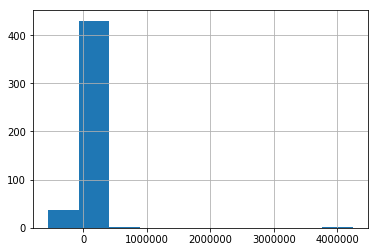

In [61]:
results_df2['difference'].hist()